<a href="https://colab.research.google.com/github/Hadrijana/Detekcja-uszkodzen-elewacji-budynk-w-za-pomoca-algorytm-w-przetwarzania-obrazu-i-sztucznej-inteligen/blob/main/mobile_net_2%2C0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn import metrics

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMAGE_RES = 224
data_dir = '/content/gdrive/MyDrive/inz_dataset'

Generator dla augmentacji danych 

In [ ]:
train_gen= ImageDataGenerator(
                              rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                shear_range=0.2,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='wrap',
                                validation_split=0.2
                                )


In [ ]:
saves = '/content/aug'

In [ ]:
train_data_gen = train_gen.flow_from_directory( directory=data_dir,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     shuffle=True,
                                                     seed=16, 
                                                     save_to_dir=saves, 
                                                     save_format="jpg",
                                                     subset="training",
                                                     class_mode='binary')

Found 995 images belonging to 3 classes.


Pobranie danych walidacyjnych oraz ich normalizacja


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=16,
  image_size=(IMAGE_RES, IMAGE_RES),
  batch_size=BATCH_SIZE)

Found 1242 files belonging to 3 classes.
Using 248 files for validation.


In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

val_dataset =  val_ds.map(normalize)

Pobranie modelelu MobileNetV2, bez warstwy klasyfikacji oraz zamrozenie wag.

In [ ]:

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_RES, IMAGE_RES, 3),
                                               include_top=False,
                                               weights='imagenet')



9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Dołożenie warstw trenowanych.

In [ ]:
inputs = tf.keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))
x=base_model(inputs, training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x =tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3)(x)
model= tf.keras.Model(inputs, outputs)


model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)


In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/aug_mobilenet_2.0'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
Funkcja zminiejszająca  wartość learning rate w późniejszych epokach.

In [ ]:
def scheduler(epoch, lr):
  if epoch < 15:
    return lr 
  else:
    return lr * tf.math.exp(-0.1)

lr_callback= tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
EPOCHS = 30
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[checkpoint_callback, lr_callback] )


Epoch 1/30
32/32 [==============================] - 526s 15s/step - loss: 0.8899 - accuracy: 0.5759 - val_loss: 0.5402 - val_accuracy: 0.7339
Epoch 2/30
32/32 [==============================] - 70s 2s/step - loss: 0.5943 - accuracy: 0.7508 - val_loss: 0.4029 - val_accuracy: 0.8427
Epoch 3/30
32/32 [==============================] - 70s 2s/step - loss: 0.5176 - accuracy: 0.7950 - val_loss: 0.3665 - val_accuracy: 0.8589
Epoch 4/30
32/32 [==============================] - 70s 2s/step - loss: 0.4965 - accuracy: 0.8080 - val_loss: 0.3635 - val_accuracy: 0.8548
Epoch 5/30
32/32 [==============================] - 70s 2s/step - loss: 0.4497 - accuracy: 0.8090 - val_loss: 0.3012 - val_accuracy: 0.8790
Epoch 6/30
32/32 [==============================] - 70s 2s/step - loss: 0.4324 - accuracy: 0.8332 - val_loss: 0.2877 - val_accuracy: 0.9113
Epoch 7/30
32/32 [==============================] - 70s 2s/step - loss: 0.3947 - accuracy: 0.8503 - val_loss: 0.2627 - val_accuracy: 0.8992
Epoch 8/30
32/32 [

In [ ]:
np.save('/content/gdrive/MyDrive/my_history_mob_3.npy',history.history)
#np.save('/content/gdrive/MyDrive/my_history2_mob_2.npy',history2.history)
#history=np.load('my_history.npy',allow_pickle='TRUE').item()

Fine tuning -> trenowane ostatnie 44 warstwy


In [ ]:
base_model.trainable = True
len(base_model.layer

154

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 110

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001/10),
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 1,747,011
Non-trainable params: 514,816
_________________________________________________________________


In [ ]:
history_fine = model.fit(train_data_gen,
                    epochs=10,
                    validation_data=val_dataset
                     )


Epoch 1/10
32/32 [==============================] - 77s 2s/step - loss: 0.6731 - accuracy: 0.7457 - val_loss: 0.4584 - val_accuracy: 0.8306
Epoch 2/10
32/32 [==============================] - 72s 2s/step - loss: 0.4849 - accuracy: 0.7970 - val_loss: 0.3348 - val_accuracy: 0.8629
Epoch 3/10
32/32 [==============================] - 72s 2s/step - loss: 0.3587 - accuracy: 0.8593 - val_loss: 0.2893 - val_accuracy: 0.8911
Epoch 4/10
32/32 [==============================] - 72s 2s/step - loss: 0.4263 - accuracy: 0.8312 - val_loss: 0.3076 - val_accuracy: 0.8629
Epoch 5/10
32/32 [==============================] - 72s 2s/step - loss: 0.3730 - accuracy: 0.8503 - val_loss: 0.2791 - val_accuracy: 0.8911
Epoch 6/10
32/32 [==============================] - 73s 2s/step - loss: 0.2899 - accuracy: 0.8894 - val_loss: 0.2363 - val_accuracy: 0.8992
Epoch 7/10
32/32 [==============================] - 72s 2s/step - loss: 0.2932 - accuracy: 0.8854 - val_loss: 0.2398 - val_accuracy: 0.9194
Epoch 8/10
32/32 [==

In [ ]:
history_fine2 = model.fit(train_data_gen,
                    epochs=5,
                    validation_data=val_dataset
                     )

Epoch 1/5
32/32 [==============================] - 70s 2s/step - loss: 0.2811 - accuracy: 0.9005 - val_loss: 0.1894 - val_accuracy: 0.9435
Epoch 2/5
32/32 [==============================] - 69s 2s/step - loss: 0.2875 - accuracy: 0.8935 - val_loss: 0.3093 - val_accuracy: 0.8710
Epoch 3/5
32/32 [==============================] - 70s 2s/step - loss: 0.2354 - accuracy: 0.9106 - val_loss: 0.1860 - val_accuracy: 0.9395
Epoch 4/5
32/32 [==============================] - 70s 2s/step - loss: 0.1705 - accuracy: 0.9327 - val_loss: 0.1443 - val_accuracy: 0.9556
Epoch 5/5
32/32 [==============================] - 69s 2s/step - loss: 0.1969 - accuracy: 0.9256 - val_loss: 0.1440 - val_accuracy: 0.9556


In [ ]:
np.save('/content/gdrive/MyDrive/my_history_fine_mob_3.npy',history_fine.history)
np.save('/content/gdrive/MyDrive/my_history_fine_mob_31.npy',history_fine2.history)

.
.
.
.
.
.
.
.
.


In [ ]:
history=np.load('/content/gdrive/MyDrive/my_history_mob_3.npy',allow_pickle='TRUE').item()
history2=np.load('/content/gdrive/MyDrive/my_history_fine_mob_3.npy',allow_pickle='TRUE').item()
history3=np.load('/content/gdrive/MyDrive/my_history_fine_mob_31.npy',allow_pickle='TRUE').item()


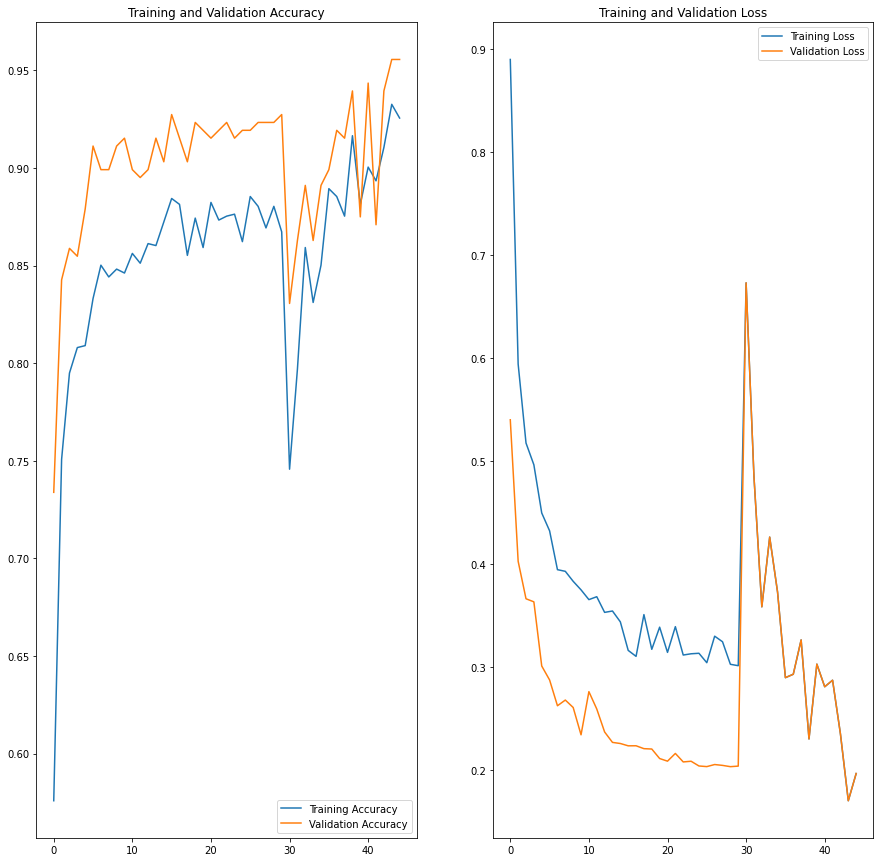

In [ ]:

acc = history['accuracy']+ history2['accuracy'] + history3['accuracy']
val_acc = history['val_accuracy'] + history2['val_accuracy'] + history3['val_accuracy']

loss = history['loss'] + history2['loss'] + history3['loss']
val_loss = history['val_loss'] + history2['loss'] + history3['loss']

epochs_range = range(45)

f=plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
f.savefig("/content/gdrive/MyDrive/mobile3.png")

zapis modelu oraz załadowanie modelu


In [ ]:
model.save("//content/gdrive/MyDrive/mobilenet-checkpoint-2/model-mobile-2")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model_loaded = tf.keras.models.load_model('/content/gdrive/MyDrive/mobilenet-checkpoint-2/model-mobile-2')


Spawdzenie dla zestawu testowego


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/gdrive/MyDrive/test_set',
  image_size=(IMAGE_RES, IMAGE_RES),
  batch_size=BATCH_SIZE)

Found 310 files belonging to 3 classes.


In [ ]:
test_dataset =  test_ds.map(normalize)

In [ ]:
loss, accuracy = model_loaded.evaluate(test_ds)
print('Test accuracy :', accuracy)



10/10 [==============================] - 14s 815ms/step - loss: 0.4626 - accuracy: 0.8161
Test accuracy : 0.8161290287971497


In [ ]:
def tests(k):
  numpy_labels= np.array([])
  numpy_images= np.array([[[[]]]])
  booll = True
  for images, labels in k.take(-1):  # only take two first elements of dataset
    if booll:
      numpy_images = images.numpy();
      booll = False
    else:
      numpy_images = np.concatenate((numpy_images, images.numpy()),axis=0)
    numpy_labels = np.concatenate((numpy_labels, labels.numpy()),axis=None)
    

  predictions = model_loaded.predict(numpy_images)
  predicted_class = np.argmax( predictions, axis=-1) 

  precision = metrics.precision_score(numpy_labels, predicted_class, average='macro')
  recall = metrics.recall_score(numpy_labels, predicted_class, average='macro')
  f1_score = metrics.f1_score(numpy_labels, predicted_class, average='macro')
  print( precision, recall, f1_score)
  cm = metrics.confusion_matrix(numpy_labels, predicted_class)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['pęknięcie', 'dziura','dobra'])

  conf_mtx = disp.plot() 
  
  plt.savefig("/content/gdrive/MyDrive/confusion_matrix1.jpg")
  return precision, recall, f1_score

Metryki precision, recall i f1 dla zestawu walidacyjnego

0.9624049361457886 0.952806676777621 0.9571281775573294


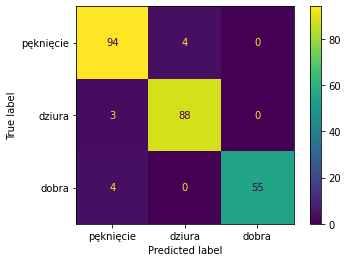

In [ ]:
precision, recall, f1_score = tests(val_dataset)

Metryki precision, recall i f1 dla zestawu testowego

0.8370876024018393 0.8135575942915393 0.8230426298372472


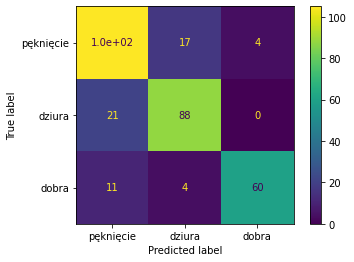

In [ ]:
precision, recall, f1_score = tests(test_dataset)